In [67]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [68]:
import numpy as np
import matplotlib.pyplot as plt

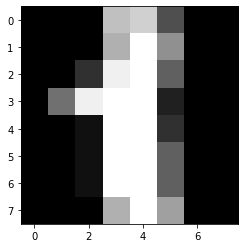

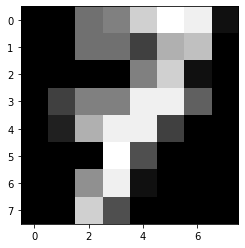

In [69]:
plt.figure()
plt.gray()
plt.imshow(images[1], interpolation="nearest")
plt.show()
plt.imshow(images[7], interpolation="nearest")
plt.show()

In [70]:
x = images[7]
x[0][6] = 0

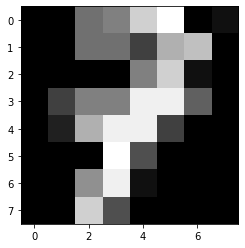

In [71]:
plt.imshow(x, interpolation="nearest")
plt.show()

In [72]:
def reduce_dim(x):
    # limit to pixel [7][4] and [0][6]
    # images is 7 if [7][4] is dark and [0][6] is white, otherwise image is 1
    return np.array([[image[7*8+4], image[0*8+6]] for image in x])

In [73]:
one_indices = np.where(target == 1)
one_labels = target[one_indices]
one_images = data[one_indices]

seven_indices = np.where(target == 7)
seven_labels = target[seven_indices]
seven_images = data[seven_indices]

one_images_reduced = reduce_dim(one_images)
seven_images_reduced = reduce_dim(seven_images)


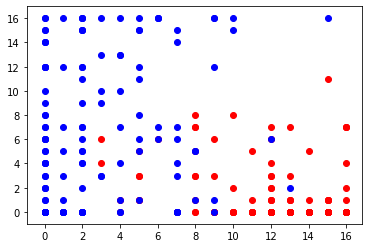

In [74]:
x1 = [ image[0] for image in one_images_reduced]
y1 = [ image[1] for image in one_images_reduced]
plt.scatter(x=x1, y=y1, c="red")
x2 = [ image[0] for image in seven_images_reduced] 
y2 = [ image[1] for image in seven_images_reduced] 
plt.scatter(x=x2, y=y2, c="blue")

In [75]:
def nearest_mean(training_features, training_labels, test_features):
    labels = np.unique(training_labels)
    mean = np.zeros((labels.size,2))
    for label in labels:
        indices = np.where(training_labels == label)
        features = training_features[indices]
        features_sum = np.sum(features, axis=0)
        features_mean = features_sum / features.size

        label_index = np.where(labels == label)
        mean[label_index] = features_mean

    def dist_vec(a, b):
        squared_diff = np.square(a[:,None] - b)
        sum_diffs = np.sum(squared_diff, axis=2)
        result = np.sqrt(sum_diffs)
        return result
    

    distances = dist_vec(test_features, mean)

    return np.array([labels[np.argmin(distance)] for distance in distances])

In [76]:
from sklearn import model_selection

X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)

one_indices_train = np.where(y_train == 1)
one_labels_train = y_train[one_indices_train]
one_images_train = X_train[one_indices_train]

seven_indices_train = np.where(y_train == 7)
seven_labels_train = y_train[seven_indices_train]
seven_images_train = X_train[seven_indices_train]

one_images_reduced_train = reduce_dim(one_images_train)
seven_images_reduced_train = reduce_dim(seven_images_train)

one_indices_test = np.where(y_test == 1)
one_labels_test = y_test[one_indices_test]
one_images_test = X_test[one_indices_test]

seven_indices_test = np.where(y_test == 7)
seven_labels_test = y_test[seven_indices_test]
seven_images_test = X_test[seven_indices_test]

one_images_reduced_test = reduce_dim(one_images_test)
seven_images_reduced_test = reduce_dim(seven_images_test)


training_features = np.concatenate((one_images_reduced_train, seven_images_reduced_train))
training_labels = np.concatenate((one_labels_train, seven_labels_train))

test_features = np.concatenate((one_images_reduced_test, seven_images_reduced_test))
test_labels = np.concatenate((one_labels_test, seven_labels_test))

In [77]:
predicted_labels = nearest_mean(training_features, training_labels, test_features)

In [78]:
np.sum((predicted_labels != test_labels)) / test_labels.size * 100

10.144927536231885

In [79]:
# find vectorized method
decision_regions = []
for i in range(200):
    for j in range(200):
        decision_regions.append([i,j])

decision_regions = np.array(decision_regions)

In [80]:
predicted_labels_decision_regions = nearest_mean(training_features, training_labels, decision_regions)

In [81]:

one_indices_decision_regions = np.where(predicted_labels_decision_regions == 1)
ones_decision_regions = decision_regions[one_indices_decision_regions]

seven_indices_decision_regions = np.where(predicted_labels_decision_regions == 7)
sevens_decision_regions = decision_regions[seven_indices_decision_regions]

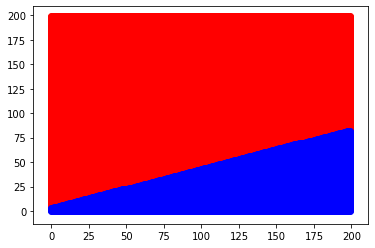

In [82]:
x1 = [ image[1] for image in ones_decision_regions]
y1 = [ image[0] for image in ones_decision_regions]
plt.scatter(x=x1, y=y1, c="red")
x2 = [ image[1] for image in sevens_decision_regions] 
y2 = [ image[0] for image in sevens_decision_regions] 
plt.scatter(x=x2, y=y2, c="blue")

1. Create classwise subsets of trainingset

For each class:

2. Learn the prior: $p(y=k) = \frac{\#TS_k }{N}$

3. $\mu_k = \frac{1}{N_k} \sum_{i \in TS_k} x_i$ and $\Sigma_k = \frac{1}{N_k} \sum_{i \in TS_k} (x_i - \mu_k)^T (x_i - \mu_k)$

In [83]:
def fit_qda(training_features, training_labels):
    # 1)
    one_indices = np.where(training_labels == 1)
    one_labels = training_labels[one_indices]
    one_features = training_features[one_indices]

    seven_indices = np.where(training_labels == 7)
    seven_labels = training_labels[seven_indices]
    seven_features = training_features[seven_indices]

    # 2)

    prior_one = one_labels.size / training_labels.size
    prior_seven = seven_labels.size / training_labels.size

    # 3)

    mu_one = np.sum(one_features, axis=0) / one_features.size
    mu_seven = np.sum(seven_features, axis=0) / seven_features.size

    sigma_one = np.dot(np.transpose((one_features - mu_one)), (one_features - mu_one)) / one_features.size
    sigma_seven = np.dot(np.transpose((seven_features - mu_seven)), (seven_features - mu_seven)) / seven_features.size

    return np.array([mu_one, mu_seven]), np.array([sigma_one, sigma_seven]), np.array([prior_one, prior_seven])


In [84]:
mu, covmat, p = fit_qda(training_features, training_labels)

In [85]:
mu.shape

(2, 2)

In [86]:
covmat.shape

(2, 2, 2)

In [87]:
p.shape

(2,)

1. Learn liklihood: $p(x|y=k) = \mathcal{N}(\mu_k, \Sigma_k)$
2. Calculate evidence: $p(x) =\sum_{k=1}^{c}p(y=k) * p(x|y=k)$
3. Calculate posterior: $(Y=k|x_{test}) = \frac{p(x_{test}|y=k) p(y=k)}{p(x_{test})}$

In [88]:
def b_k(cov, p):
    return np.log(np.sqrt(np.linalg.det(2 * np.pi * covmat))) - np.log(p)

In [89]:
def predict_qda(mu, covmat, p, test_features):
    return np.array([np.argmin([0.5 * (x_i - mu[k]).dot(np.linalg.inv(covmat[k])).dot((x_i - mu[k])) + b_k(covmat, p)[k] for k in [0, 1]])
               for x_i in test_features])

In [96]:
predict_qda(mu, covmat, p, test_features)

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])